In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os
import pathlib
import pandas
import csv
import keras

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [2]:
img_folder = r"data"
df = pandas.read_csv("CoordinateList.csv")
tups = []
for row in df[["NAME", "Label"]].iterrows():
    name = row[1]["NAME"]
    label = row[1]["Label"]
    file_path = os.path.join(img_folder, name)
    for file in os.listdir(file_path):
        # open image and save in the object
        Str = file_path + str("\\") + file
        img_object = cv2.imread(Str)
        img_object_64 = cv2.resize(img_object, (224, 224))
        img_object = np.array(img_object_64)/255
        tups.append((file, img_object_64, img_object, label))
#         print(img_object.shape)

tups[0]
# for monument in df[["NAME", "Label"]]:
#     x = os.listdir(os.path.join(img_folder, monument))
#     print(monument)

('Taj Mahal.png',
 array([[[61, 56, 53],
         [63, 58, 49],
         [60, 55, 45],
         ...,
         [31, 13, 14],
         [30, 12, 13],
         [32, 14, 14]],
 
        [[56, 51, 47],
         [53, 47, 42],
         [51, 45, 37],
         ...,
         [31, 13, 14],
         [31, 13, 14],
         [32, 14, 15]],
 
        [[57, 51, 45],
         [58, 50, 46],
         [55, 48, 43],
         ...,
         [32, 14, 15],
         [30, 12, 13],
         [32, 14, 15]],
 
        ...,
 
        [[61, 53, 63],
         [54, 45, 56],
         [52, 43, 51],
         ...,
         [25,  9, 13],
         [51, 48, 54],
         [57, 54, 59]],
 
        [[51, 42, 49],
         [43, 32, 40],
         [42, 31, 38],
         ...,
         [26, 11, 16],
         [54, 51, 59],
         [68, 64, 72]],
 
        [[42, 32, 38],
         [36, 23, 29],
         [36, 22, 28],
         ...,
         [31, 18, 24],
         [62, 58, 68],
         [78, 74, 84]]], dtype=uint8),
 array([[[0.23921569, 0.

In [3]:
X = []
Y = []
names = []
for name, img, x_, y_ in tups:
    X.append((name, img, x_))
    Y.append(float(y_))
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, random_state=0, train_size=0.9)
X_train_names = [_[0] for _ in X_train_orig]
X_train_images = [_[1] for _ in X_train_orig]
X_train = np.array([_[2] for _ in X_train_orig])
X_test_names = [_[0] for _ in X_test_orig]
X_test_images = [_[1] for _ in X_test_orig]
X_test = np.array([_[2] for _ in X_test_orig])
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(X_train.shape)
print(Y_train.shape)
#X_train = np.array(X_train_orig[1])
#X_test = np.array(X_test_orig[1])
#X_train
#X = np.array(X)
#Y = np.array(Y)

#print("Train Size", len(X_train))
#print("Test Size", len(X_test))
#X_train.shape

(345, 224, 224, 3)
(345,)


In [4]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=X_train.shape[1:], trainable=False)

cnn = models.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(10, activation='relu'),
#     layers.Conv2D(filters=41, kernel_size=(3, 3), activation='relu'), #input_shape=X_train.shape[1:]
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(filters=25, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(filters=7, kernel_size=(5, 5), activation='relu'),    
#     layers.Conv2D(filters=3, kernel_size=(5, 5), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(15, activation='relu'), 
#     layers.Dense(7, activation='relu'),
#     layers.Dense(3, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [5]:
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,270,805
Trainable params: 12,821
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
cnn.fit(X_train, Y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 9s 89ms/step - loss: 0.4630 - tp: 181.0000 - fp: 44.0000 - tn: 86.0000 - fn: 34.0000 - accuracy: 0.7739 - precision: 0.8044 - recall: 0.8419 - auc: 0.8588 - prc: 0.8942
Epoch 2/100
11/11 [==============================] - 0s 44ms/step - loss: 0.2068 - tp: 203.0000 - fp: 10.0000 - tn: 120.0000 - fn: 12.0000 - accuracy: 0.9362 - precision: 0.9531 - recall: 0.9442 - auc: 0.9705 - prc: 0.9788
Epoch 3/100
11/11 [==============================] - 0s 44ms/step - loss: 0.1570 - tp: 211.0000 - fp: 10.0000 - tn: 120.0000 - fn: 4.0000 - accuracy: 0.9594 - precision: 0.9548 - recall: 0.9814 - auc: 0.9838 - prc: 0.9891
Epoch 4/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0942 - tp: 212.0000 - fp: 4.0000 - tn: 126.0000 - fn: 3.0000 - accuracy: 0.9797 - precision: 0.9815 - recall: 0.9860 - auc: 0.9971 - prc: 0.9983
Epoch 5/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0664 - tp: 213.0000 - fp: 6.0000 - t

11/11 [==============================] - 0s 44ms/step - loss: 0.0018 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 37/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0017 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 38/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0016 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 39/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0016 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 40/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0015 - tp: 215.0

11/11 [==============================] - 1s 46ms/step - loss: 5.0469e-04 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 72/100
11/11 [==============================] - 0s 45ms/step - loss: 4.9061e-04 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 73/100
11/11 [==============================] - 0s 45ms/step - loss: 4.7974e-04 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 74/100
11/11 [==============================] - 0s 44ms/step - loss: 4.6584e-04 - tp: 215.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 75/100
11/11 [==============================] - 0s 44ms/step - loss: 4.

In [8]:
cnn.evaluate(X_test, Y_test)

2/2 [==============================] - 1s 353ms/step - loss: 0.0184 - tp: 19.0000 - fp: 0.0000e+00 - tn: 20.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


[0.018368929624557495, 19.0, 0.0, 20.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [9]:
def plot_sample(x, y, name):
    plt.figure(figsize = (15,2))
    plt.imshow(x)
    plt.xlabel("Predict: " + ("\"Monument\" " if y >= 0.5 else "\"Random\" ") + "Actual: \""+ str(name) +"\"")

Total tests: 39
All positives: 19
Correct Predictions: 


C:\Users\anike\AppData\Local\Temp/ipykernel_19980/2145563649.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (15,2))


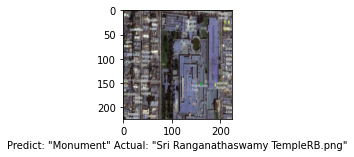

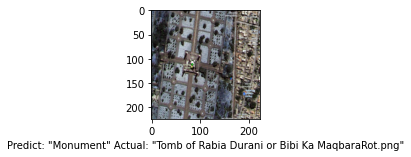

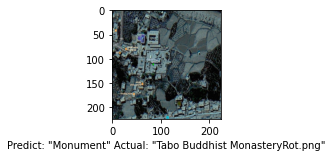

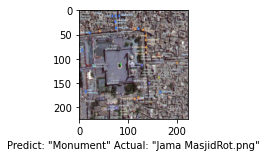

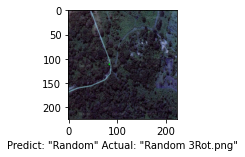

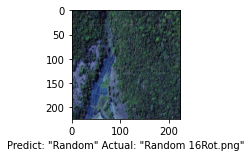

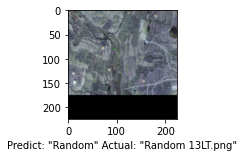

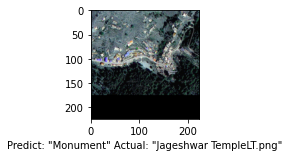

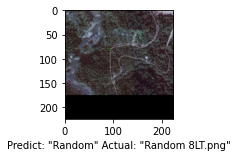

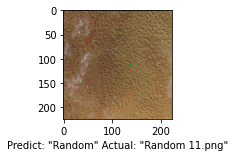

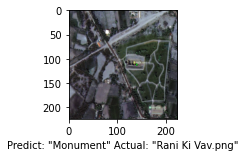

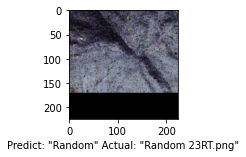

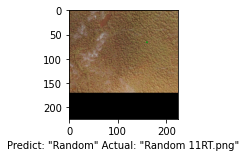

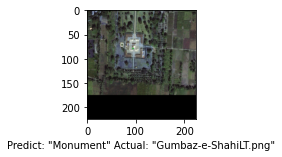

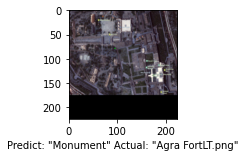

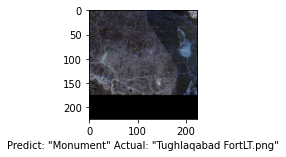

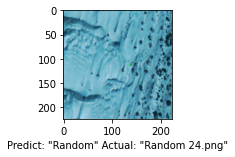

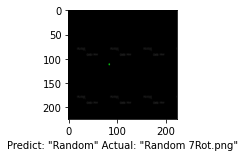

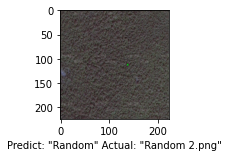

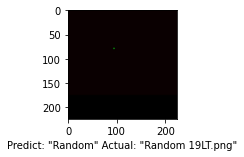

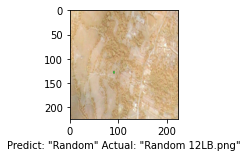

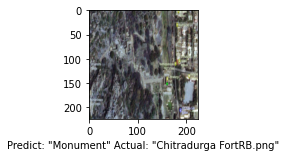

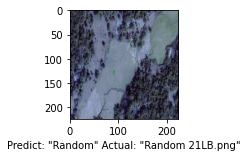

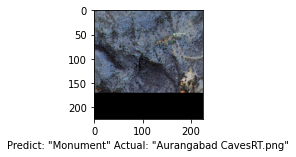

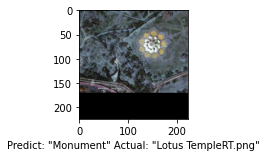

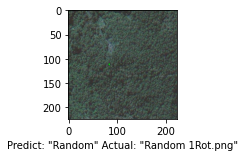

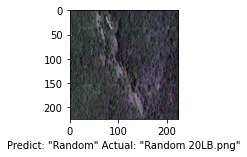

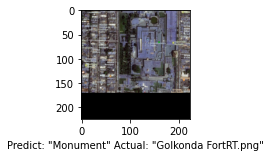

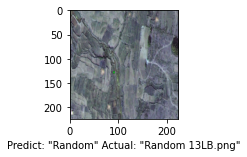

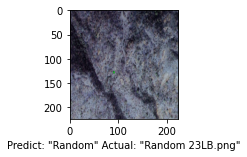

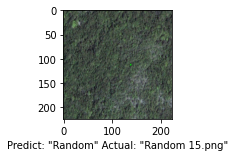

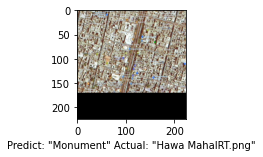

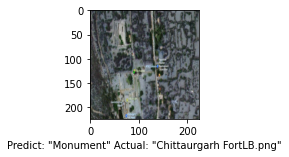

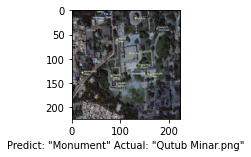

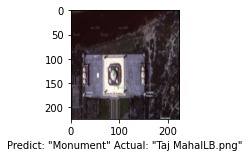

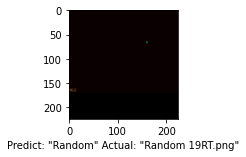

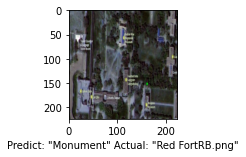

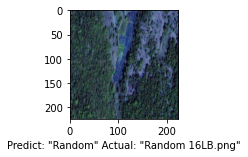

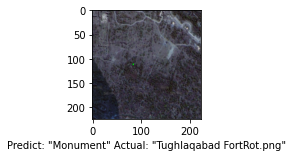

In [10]:
Y_pred = cnn(X_test)
actuals = [1 if pred >= 0.5 else 0 for pred in Y_test]
preds = [1 if pred >= 0.5 else 0 for pred in Y_pred]
print("Total tests:", len(preds))
print("All positives:", sum(preds))

print("Correct Predictions: ")
for name, img, pred, actual in zip(X_test_names, X_test_images, preds, actuals):
    if pred == actual:
        plot_sample(img, pred, name)

In [11]:
print("Wrong Predictions: ")
for name, img, pred, actual in zip(X_test_names, X_test_images, preds, actuals):
    if pred != actual:
        plot_sample(img, pred, name)

Wrong Predictions: 
